<a href="https://colab.research.google.com/github/N-nolwenn/RepositoryTest/blob/main/Final%20Fall_armyworm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing the relevant libraries
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import random
from IPython.display import Image as ShowImage

# Keras libraries
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization,GlobalMaxPooling2D
from tensorflow.keras.applications.vgg16 import VGG16 #16개의 레이어를 제공하는 CNN 아키텍처(사전 훈련된 네트워크로 재사용 가능)
from keras.preprocessing.image import ImageDataGenerator # 실시간 데이터 증식으로 텐서 이미지 데이터의 배치를 생성.(크기 조정, 회전, 확대/축소)
from tensorflow.keras import optimizers
from keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import files
myfile = files.upload()

Saving Test1.csv to Test1.csv
Saving Train1.csv to Train1.csv


In [ ]:
# Reading the data
train_labels = pd.read_csv("Train1.csv")
# Show the first 5 rows
train_labels.head()

,Image_id,Label
0,id_02amazy34fgh2.jpg,1
1,id_02mh3w48pmyc9.jpg,0
2,id_02rpb463h9d3w.jpg,0
3,id_02wc3jeeao8ol.jpg,1
4,id_03t2hapb8wz8p.jpg,1


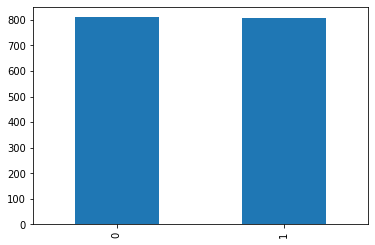

In [ ]:
train_labels['Label'].value_counts().plot.bar()

**가을 거위충에 영향을 받은 옥수수 작물 이미지와 그렇지 않은 이미지 데이터의 수가 비슷**
**--> The number of images of corn crops affected by autumn geese and the number of image data that are not**

In [ ]:
from google.colab import files
myfile = files.upload()

Saving Images.zip to Images.zip


In [ ]:
import zipfile
with zipfile.ZipFile("Images.zip", 'r') as zip_ref:
    zip_ref.extractall("targetdir")

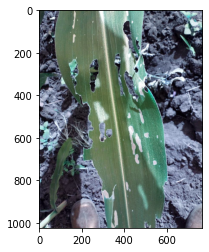

In [ ]:
import cv2
import random
import os

# This stores the location of the data source
data = os.listdir("targetdir")
# Picking random sample from data list
sample = random.choice(data)
# The imread method loads image from the sprcified file
img = cv2.imread("targetdir/"+sample)
# The cmap parameter displays the image in gray
plt.imshow(img, cmap="gray")

In [ ]:
#Replace 0 and 1 with whether they are affected by pests
train_labels["Label"] = train_labels["Label"].replace({0: 'notaffected', 1: 'affected'})

In [ ]:
# Defining how data is passed to the input layer 
image_size = 224
input_shape = (image_size, image_size, 3) #(Image Height, Image Width, Image Channel)
batch_size = 16

First we specify that our pre trained model will be implemented through VGG16's transfer learning. After initialising our pretrained model as a sequential one we create the structure of our CNN model as shown below: (image)
We set the filter size of convolution layers as 64 for the block 1, 128 for the block 2, 256 for the block 3, 512 for the block 4 & 5. 

For all convolution layers we set the kernel size as (3,3) with a stride 1 and always used same padding.

We use 2by2 maxpooling with stride 2.

We also set a Global maxpooling where the pooling size is equal to the input size leading to the maximum value of the entire input being connected to the output value

After the globalMaxpooling we set the number of filters in the dense layer as 512 and use the relu function for activation.

We also add a dropout layer with dropout probability 0.5

After the droppout we set the number of filters in the dense layer as 512 and use the softmax function for activation.

We compile our model using the binary crossentropy loss because we are dealing with a binary classification.
We use the stochastic gradient descent optimizer and set the evaluation metric to accuracy because it is a classification problem. 

In [ ]:
pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
# The include_top parameter determines whether to include the output layer, which is false because the output layer of the VGG16 model is not required for our classification problem
# The weights parameter specifies a weight checkpoint to initialize the model
# The input_shape parameter is the size of the image tensor to enter into the network

for layer in pre_trained_model.layers[:15]:
  layer.trainable = False
for layer in pre_trained_model.layers[15:]:
  layer.trainable = True
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output

x = GlobalMaxPooling2D()(last_output) #GlobalMaxPooling2D - Another type of pooling in which the pooling size is set equal to the input size, leading to the maximum value of the entire input being connected to the output value
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy', #Binary classification
optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), #stochastic gradient descent
metrics=["AUC"]) #Set to AUC because it is a classification problem
model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


1. Input layer - Input layer reads image. The image is displayed in a 3D matrix. Dimensions are height, width, and channel. Width and height are reduced as the network gets deeper.
2. Convolutional layer - Image features such as edges are extracted from within this layer.
3. Pooling layer - This layer reduces image dimension size. The purpose of this layer is to reduce the computational ability when processing data by reducing the image size. This reduces the likelihood of overfitting in the long run (you can see that the image size decreases as it passes through the MaxPooling2D layer)
4. Fully-connected layer - This layer is trained to classify images between different categories, ie nonlinear combinations of high -level features represented by the output of the convolution layer.
5. Output layer - Include final label (0 or 1)

After the creation of the model, we import EarlyStopping, ReduceLROnPlanteau and train_test_split methods form keras. 

We implement an early termination. This callback will stop the training when there is no improvement in the loss for ten consecutive epochs.

RedueLROnPlateau is used to reduce the learning rates when the accuracy improvement are interrupted.

train_test_split is used to split the training data into a train and validation sets. 

In [ ]:
# Implementation of early termination.
from keras.callbacks import ReduceLROnPlateau

#earlystop = EarlyStopping(patience=10)
# ReduceLRonPlateau calls back to reduce learning rates when accuracy improvements are interrupted
# The patency parameter is the number of epochs that have not improved since the learning rate has decreased

#learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5,min_lr=0.00001)
#callbacks = [earlystop, learning_rate_reduction]

callbacks = ReduceLROnPlateau(monitor='val_auc',patience=2,verbose=1,factor=0.5,min_lr=0.00001)

In [ ]:
# train_test_split Using methods to divide training data into training and validation datasets
from sklearn.model_selection import train_test_split

train_df,validate_df=train_test_split(train_labels,test_size=0.2,random_state=42)
train_df = train_df.reset_index(drop='True')
validate_df = validate_df.reset_index(drop='True')

In [ ]:
# Generate batches of tensor image data with real-time data augmentation
from keras.preprocessing.image import ImageDataGenerator, load_img

# Categorical encodes categorical variables 
from tensorflow.keras.utils import to_categorical

For training, we use data augmentation. 

Here We are creating and using ImageDataGenerator for both training and validation data and passing the folder which has train_generator to the object train_datagen and similarly passing the folder which has validation generator to the object validation_datagen. 

The folder structure of the data will be as follows: (image entitled: Folder structure of the data to passed to ImageDataGenerator)

The ImageDataGenerator will automatically label all the data inside "Not Affected" folder as non affected leaves and same for the affected ones. 
In this way, data is easily ready to be passed to the neural network. 

We then apply different function on the train_datagen to formate the training data. We apply rotation,rescale, zoom, horizontal flip, width shift and height shift

For the formatting of the validation data we simply apply rescale. 

In [ ]:
# Here we are formatting the training data 
train_datagen = ImageDataGenerator(rotation_range=15,
                                 rescale=1./255,
                                 shear_range=0.1,
                                 zoom_range=0.2, # zoom range (1-0.2 to 1+0.2)
                                 horizontal_flip=True,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                  directory="targetdir/",
                                                  x_col="Image_id",
                                                  y_col="Label",
                                                  target_size=(image_size,image_size),
                                                  class_mode='binary',
                                                  batch_size=15)

# Here we are formatting images on the validation data 
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(validate_df,
                                                  directory="targetdir/",
                                                  x_col="Image_id",
                                                  y_col="Label",
                                                  target_size=(image_size,image_size),
                                                  class_mode='binary',
                                                  batch_size=15)

Found 1295 validated image filenames belonging to 2 classes.
Found 324 validated image filenames belonging to 2 classes.


We train the model using the training dataset and run it for 100 epochs). All the training/validation accuracy and loss are stored in history variable. Once we trained the model we can visualize the training/validation accuracy and loss. 

In [ ]:
#Train the model using the training dataset and run it for 100 epochs
epochs=100 

total_validate = validate_df.shape[0]
total_train = train_df.shape[0]

history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/100
80/80 [==============================] - 52s 467ms/step - loss: 0.7441 - auc: 0.6079 - val_loss: 0.6037 - val_auc: 0.8261 - lr: 1.0000e-04
Epoch 2/100
80/80 [==============================] - 36s 451ms/step - loss: 0.6028 - auc: 0.7929 - val_loss: 0.4708 - val_auc: 0.9306 - lr: 1.0000e-04
Epoch 3/100
80/80 [==============================] - ETA: 0s - loss: 0.4794 - auc: 0.8981
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
80/80 [==============================] - 36s 452ms/step - loss: 0.4794 - auc: 0.8981 - val_loss: 0.3397 - val_auc: 0.9705 - lr: 1.0000e-04
Epoch 4/100
80/80 [==============================] - 36s 455ms/step - loss: 0.3730 - auc: 0.9462 - val_loss: 0.2772 - val_auc: 0.9797 - lr: 5.0000e-05
Epoch 5/100
80/80 [==============================] - ETA: 0s - loss: 0.3011 - auc: 0.9702
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
80/80 [==============================] - 38s 471ms/step - loss: 0.3011 - auc

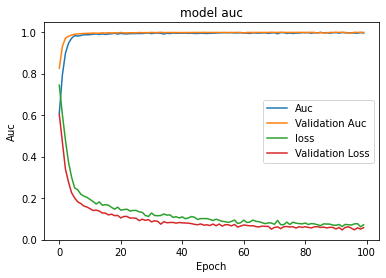

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history["auc"])
plt.plot(history.history['val_auc'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model auc")
plt.ylabel("Auc")
plt.xlabel("Epoch")
plt.legend(["Auc","Validation Auc","loss","Validation Loss"])
plt.show()

In [ ]:
# Reading the data
test_labels = pd.read_csv("Test1.csv")
# Show the first 5 rows
test_labels.head()

,Image_id
0,id_00exusbkgzw1b.jpg
1,id_03dqinf6w0znv.jpg
2,id_046yl0cxn3ybz.jpg
3,id_04athdtx2abyg.jpg
4,id_062aauf9e9jk0.jpg


In [ ]:
#creating a test dataframe with images and the target is unmask for all images
test = pd.DataFrame({
    'image': test_labels["Image_id"],
    'target':"affected"
})
test.head()

,image,target
0,id_00exusbkgzw1b.jpg,affected
1,id_03dqinf6w0znv.jpg,affected
2,id_046yl0cxn3ybz.jpg,affected
3,id_04athdtx2abyg.jpg,affected
4,id_062aauf9e9jk0.jpg,affected


In [ ]:
len(test)

1080

In [ ]:
#Finally, pass the test data to the ImageDataGenerator to fit the model to the test data
test_gen = ImageDataGenerator(rescale=1./255)

test_labels = test_labels.reset_index(drop='True')
test_generator = test_gen.flow_from_dataframe(
    dataframe=test,
    directory="targetdir/",
    x_col="image",
    y_col="target",
    target_size=(image_size,image_size),
    class_mode='categorical',
    batch_size=15,
    shuffle=False)
nb_samples = test.shape[0]
#The model.predict_generator helps predict new image data.

predict = model.predict_generator(test_generator)

Found 1080 validated image filenames belonging to 1 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


In [ ]:
test.shape[0]

1080

In [ ]:
len(predict)

1080

In [ ]:
# Here we are converting the submission data to a dataframe
# Save the predict object that stores the predicted results above in the target row of the test dataset.
test_labels["Label"]=predict

#here we are converting to a csv file
test_labels.to_csv("submission.csv",index=False)

In [ ]:
pwd

'/content'